## Dataset Description
In this competition your task is to predict whether a passenger was transported to an alternate dimension during the Spaceship Titanic's collision with the spacetime anomaly. To help you make these predictions, you're given a set of personal records recovered from the ship's damaged computer system.

### File and Data Field Descriptions

- train.csv - Personal records for about two-thirds (~8700) of the passengers, to be used as training data.


- PassengerId - A unique Id for each passenger. Each Id takes the form gggg_pp where gggg indicates a group the passenger is travelling with and pp is their number within the group. People in a group are often family members, but not always.
- HomePlanet - The planet the passenger departed from, typically their planet of permanent residence.
- CryoSleep - Indicates whether the passenger elected to be put into suspended animation for the duration of the voyage. Passengers in cryosleep are confined to their cabins.
- Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
- Destination - The planet the passenger will be debarking to.
- Age - The age of the passenger.
- VIP - Whether the passenger has paid for special VIP service during the voyage.
- RoomService, FoodCourt, ShoppingMall, Spa, VRDeck - Amount the passenger has billed at each of the Spaceship Titanic's many luxury amenities.
- Name - The first and last names of the passenger.
- Transported - Whether the passenger was transported to another dimension. This is the target, the column you are trying to predict.


test.csv - Personal records for the remaining one-third (~4300) of the passengers, to be used as test data. Your task is to predict the value of Transported for the passengers in this set.


sample_submission.csv - A submission file in the correct format.


- PassengerId - Id for each passenger in the test set.
- Transported - The target. For each passenger, predict either True or False.

In [1]:
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.model_selection import train_test_split

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.models import Sequential


import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

2024-02-27 16:45:56.262900: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-27 16:45:56.263041: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-27 16:45:56.433716: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# load datasets
sample = pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")
train = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")

In [3]:
train_nan = train.copy(deep = True)
test_nan = test.copy(deep = True)

In [4]:
train_nan

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [5]:
# categorize features
features_num_nan = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "RoomService"]
features_cat_nan = ["HomePlanet", "CryoSleep", "Destination", "VIP"]
target_nan = ["Transported"]

In [6]:
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [7]:
test

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0013_01,Earth,True,G/3/S,TRAPPIST-1e,27.0,False,0.0,0.0,0.0,0.0,0.0,Nelly Carsoning
1,0018_01,Earth,False,F/4/S,TRAPPIST-1e,19.0,False,0.0,9.0,0.0,2823.0,0.0,Lerome Peckers
2,0019_01,Europa,True,C/0/S,55 Cancri e,31.0,False,0.0,0.0,0.0,0.0,0.0,Sabih Unhearfus
3,0021_01,Europa,False,C/1/S,TRAPPIST-1e,38.0,False,0.0,6652.0,0.0,181.0,585.0,Meratz Caltilter
4,0023_01,Earth,False,F/5/S,TRAPPIST-1e,20.0,False,10.0,0.0,635.0,0.0,0.0,Brence Harperez
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,9266_02,Earth,True,G/1496/S,TRAPPIST-1e,34.0,False,0.0,0.0,0.0,0.0,0.0,Jeron Peter
4273,9269_01,Earth,False,NaN,TRAPPIST-1e,42.0,False,0.0,847.0,17.0,10.0,144.0,Matty Scheron
4274,9271_01,Mars,True,D/296/P,55 Cancri e,NaN,False,0.0,0.0,0.0,0.0,0.0,Jayrin Pore
4275,9273_01,Europa,False,D/297/P,NaN,NaN,False,0.0,2680.0,0.0,0.0,523.0,Kitakan Conale


In [8]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8693 entries, 0 to 8692
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   8693 non-null   object 
 1   HomePlanet    8492 non-null   object 
 2   CryoSleep     8476 non-null   object 
 3   Cabin         8494 non-null   object 
 4   Destination   8511 non-null   object 
 5   Age           8514 non-null   float64
 6   VIP           8490 non-null   object 
 7   RoomService   8512 non-null   float64
 8   FoodCourt     8510 non-null   float64
 9   ShoppingMall  8485 non-null   float64
 10  Spa           8510 non-null   float64
 11  VRDeck        8505 non-null   float64
 12  Name          8493 non-null   object 
 13  Transported   8693 non-null   bool   
dtypes: bool(1), float64(6), object(7)
memory usage: 891.5+ KB


In [9]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4277 entries, 0 to 4276
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   PassengerId   4277 non-null   object 
 1   HomePlanet    4190 non-null   object 
 2   CryoSleep     4184 non-null   object 
 3   Cabin         4177 non-null   object 
 4   Destination   4185 non-null   object 
 5   Age           4186 non-null   float64
 6   VIP           4184 non-null   object 
 7   RoomService   4195 non-null   float64
 8   FoodCourt     4171 non-null   float64
 9   ShoppingMall  4179 non-null   float64
 10  Spa           4176 non-null   float64
 11  VRDeck        4197 non-null   float64
 12  Name          4183 non-null   object 
dtypes: float64(6), object(7)
memory usage: 434.5+ KB


In [10]:
train.isnull().sum().sum()

2324

In [11]:
# check for missing values
datasets = [train, test]
for data in datasets:
    print(data.isnull().sum())
    print("-"*20)

PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64
--------------------
PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64
--------------------


In [12]:
# check for missing values when passenger is in cryosleep
datasets = [train[train["CryoSleep"] == True], test[test["CryoSleep"] == True]]
for data in datasets:
    print(data.isnull().sum())
    print("-"*20)

PassengerId      0
HomePlanet      75
CryoSleep        0
Cabin           84
Destination     48
Age             82
VIP             75
RoomService     68
FoodCourt       70
ShoppingMall    96
Spa             65
VRDeck          62
Name            62
Transported      0
dtype: int64
--------------------
PassengerId      0
HomePlanet      28
CryoSleep        0
Cabin           35
Destination     32
Age             32
VIP             29
RoomService     25
FoodCourt       39
ShoppingMall    35
Spa             42
VRDeck          29
Name            36
dtype: int64
--------------------


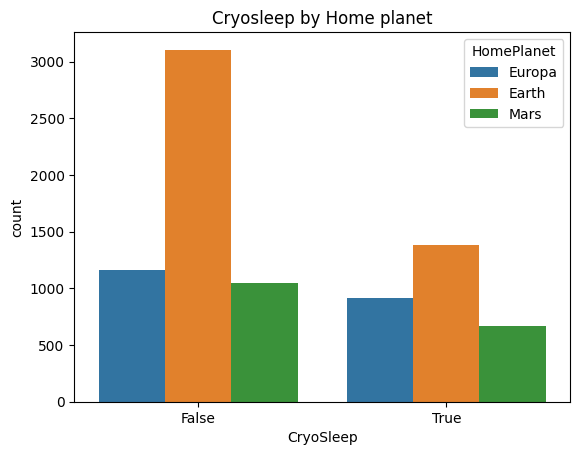

In [13]:
sns.countplot(train, x = "CryoSleep", hue = "HomePlanet")
plt.title("Cryosleep by Home planet")
plt.show()

<Axes: >

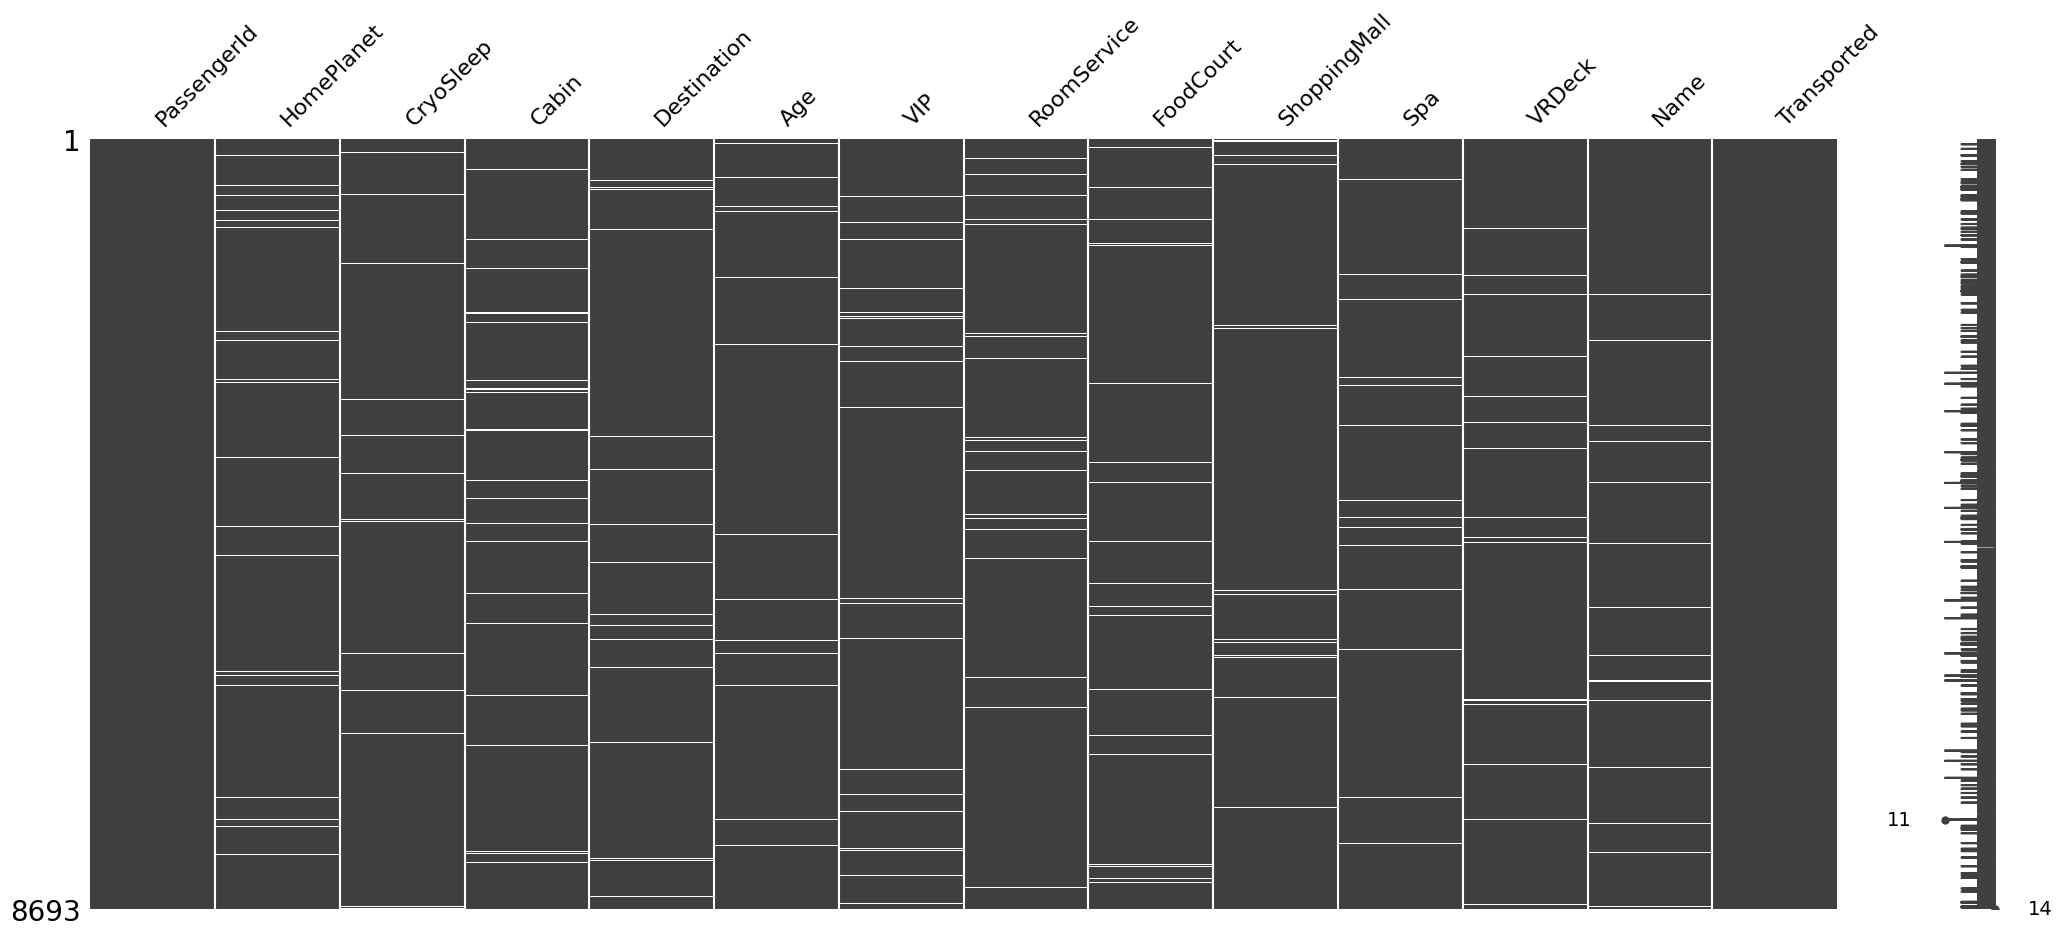

In [14]:
# check position of missing values
msno.matrix(train)

<Axes: >

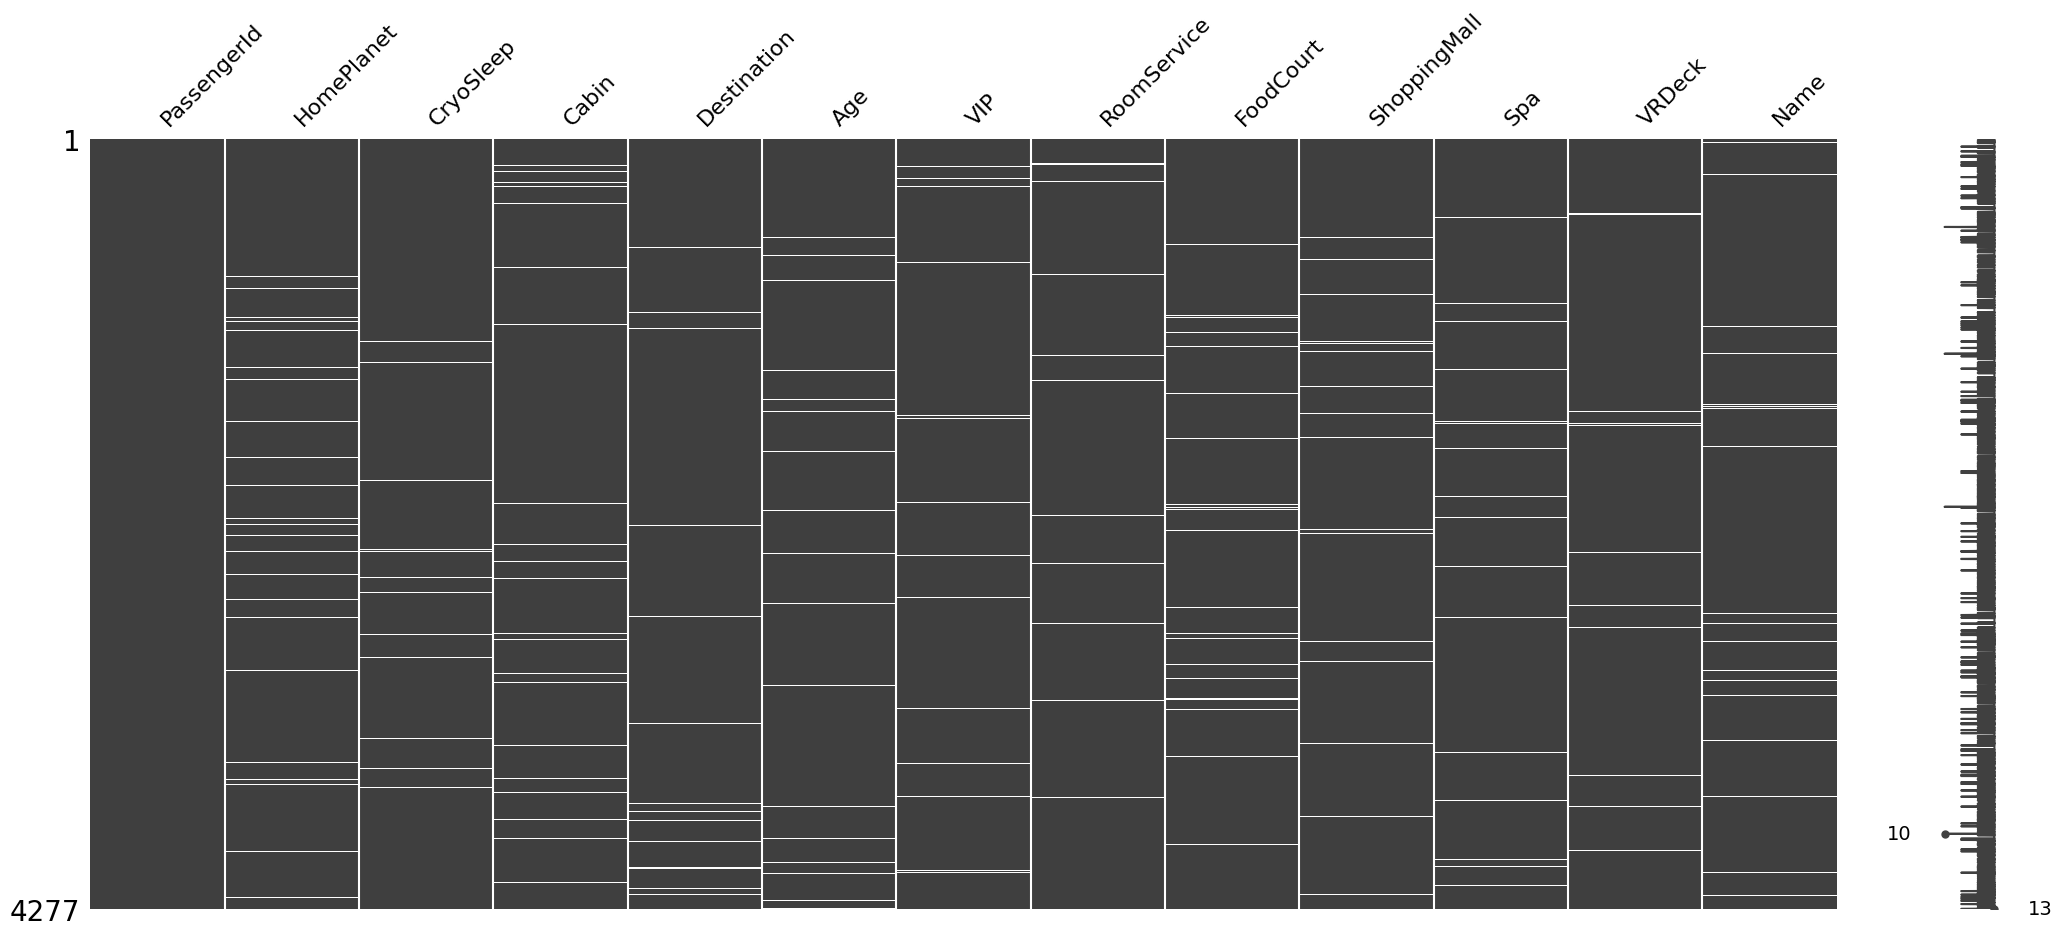

In [15]:
msno.matrix(test)

In [16]:
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False


In [17]:
# first 4 numbers of "PassengeId" column indicates a group in which passenger is traveling
train["PassengerId"].str[:4].value_counts().count()

6217

In [18]:
# create group_id column
datasets = [train, test]
for data in datasets:
    data["group_id"] = data["PassengerId"].str[:4]

In [19]:
train["group_id"].value_counts()

group_id
4498    8
8168    8
8728    8
8796    8
8956    8
       ..
3483    1
3480    1
3478    1
3473    1
4620    1
Name: count, Length: 6217, dtype: int64

In [20]:
train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,group_id
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,A/98/P,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,9276
8689,9278_01,Earth,True,G/1499/S,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,9278
8690,9279_01,Earth,False,G/1500/S,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,9279
8691,9280_01,Europa,False,E/608/S,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,9280


In [21]:
train["HomePlanet"].value_counts(dropna = False)

HomePlanet
Earth     4602
Europa    2131
Mars      1759
NaN        201
Name: count, dtype: int64

In [22]:
train["CryoSleep"].value_counts(dropna = False)

CryoSleep
False    5439
True     3037
NaN       217
Name: count, dtype: int64

In [23]:
# Cabin - The cabin number where the passenger is staying. Takes the form deck/num/side, where side can be either P for Port or S for Starboard.
train["Cabin"].str[:1].value_counts(dropna = False)

Cabin
F      2794
G      2559
E       876
B       779
C       747
D       478
A       256
NaN     199
T         5
Name: count, dtype: int64

In [24]:
train["Cabin"].str[-1].value_counts(dropna = False)

Cabin
S      4288
P      4206
NaN     199
Name: count, dtype: int64

In [25]:
# create "deck" and "side" column and drop "Cabin" column
for data in datasets:
    data["deck"] = data["Cabin"].str[:1]
    data["side"] = data["Cabin"].str[-1]
    data.drop(columns = ["Cabin"], inplace = True)

In [26]:
train

,PassengerId,HomePlanet,CryoSleep,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported,group_id,deck,side
0,0001_01,Europa,False,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False,0001,B,P
1,0002_01,Earth,False,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True,0002,F,S
2,0003_01,Europa,False,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False,0003,A,S
3,0003_02,Europa,False,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False,0003,A,S
4,0004_01,Earth,False,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True,0004,F,S
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,55 Cancri e,41.0,True,0.0,6819.0,0.0,1643.0,74.0,Gravior Noxnuther,False,9276,A,P
8689,9278_01,Earth,True,PSO J318.5-22,18.0,False,0.0,0.0,0.0,0.0,0.0,Kurta Mondalley,False,9278,G,S
8690,9279_01,Earth,False,TRAPPIST-1e,26.0,False,0.0,0.0,1872.0,1.0,0.0,Fayey Connon,True,9279,G,S
8691,9280_01,Europa,False,55 Cancri e,32.0,False,0.0,1049.0,0.0,353.0,3235.0,Celeon Hontichre,False,9280,E,S


In [27]:
train["Destination"].value_counts(dropna = False)

Destination
TRAPPIST-1e      5915
55 Cancri e      1800
PSO J318.5-22     796
NaN               182
Name: count, dtype: int64

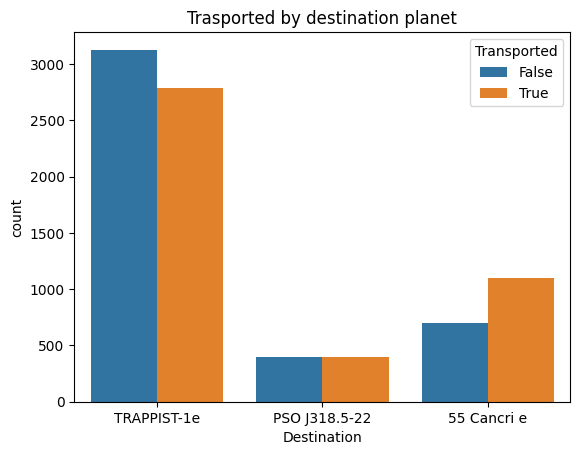

In [28]:
sns.countplot(train, x = "Destination", hue = "Transported")
plt.title("Trasported by destination planet")
plt.show()

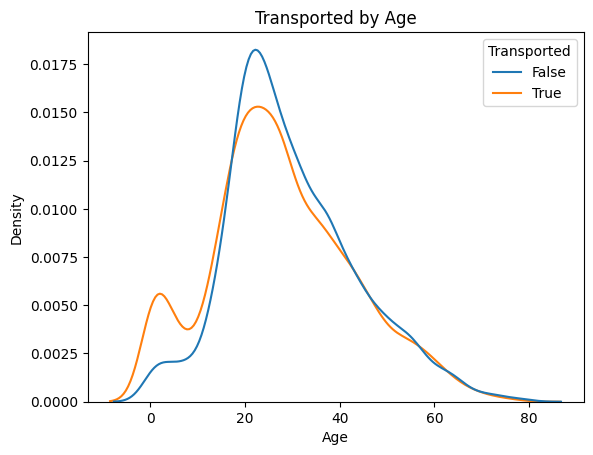

In [29]:
sns.kdeplot(train, x = "Age", hue = "Transported")
plt.title("Transported by Age")
plt.show()

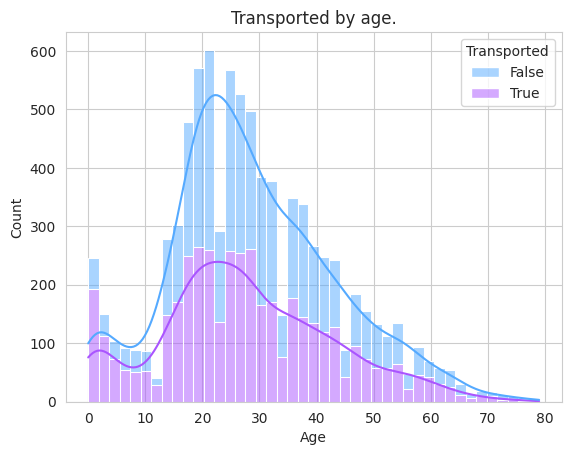

In [30]:
sns.set_style("whitegrid")

sns.histplot(train, x = "Age", hue = "Transported", multiple = "stack", kde = True, palette = "cool")
plt.title("Transported by age.")
plt.show()

In [31]:
pd.qcut(train["Age"], 10).value_counts().sort_index()

Age
(-0.001, 13.0]    947
(13.0, 18.0]      918
(18.0, 21.0]      881
(21.0, 24.0]      907
(24.0, 27.0]      770
(27.0, 31.0]      882
(31.0, 35.0]      696
(35.0, 41.0]      911
(41.0, 49.0]      791
(49.0, 79.0]      811
Name: count, dtype: int64

In [32]:
# Map both dfs "Age" columns based on the train bins
for data in datasets:
    data["age"] = np.nan
    data.loc[data["Age"] <= 13, "age"] = 0
    data.loc[(data["Age"] > 13) & (data["Age"] <= 18), "age"] = 1
    data.loc[(data["Age"] > 18) & (data["Age"] <= 21), "age"] = 2
    data.loc[(data["Age"] > 21) & (data["Age"] <= 24), "age"] = 3
    data.loc[(data["Age"] > 24) & (data["Age"] <= 27), "age"] = 4
    data.loc[(data["Age"] > 27) & (data["Age"] <= 31), "age"] = 5
    data.loc[(data["Age"] > 31) & (data["Age"] <= 35), "age"] = 6
    data.loc[(data["Age"] > 35) & (data["Age"] <= 41), "age"] = 7
    data.loc[(data["Age"] > 41) & (data["Age"] <= 49), "age"] = 8
    data.loc[data["Age"] > 49, "age"] = 9
    
    # Drop "Age" and "Age_qband" columns
    data.drop(columns = ["Age"], inplace = True)

In [33]:
# create "spent" column for all spending
for data in datasets:
    data["spent"] = data["RoomService"] + data["FoodCourt"] + data["ShoppingMall"] + data["Spa"] + data["VRDeck"]

In [34]:
# drop "Name" colun
for data in datasets:
    data.drop(columns = ["Name"], inplace = True)

In [35]:
train

,PassengerId,HomePlanet,CryoSleep,Destination,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Transported,group_id,deck,side,age,spent
0,0001_01,Europa,False,TRAPPIST-1e,False,0.0,0.0,0.0,0.0,0.0,False,0001,B,P,7.0,0.0
1,0002_01,Earth,False,TRAPPIST-1e,False,109.0,9.0,25.0,549.0,44.0,True,0002,F,S,3.0,736.0
2,0003_01,Europa,False,TRAPPIST-1e,True,43.0,3576.0,0.0,6715.0,49.0,False,0003,A,S,9.0,10383.0
3,0003_02,Europa,False,TRAPPIST-1e,False,0.0,1283.0,371.0,3329.0,193.0,False,0003,A,S,6.0,5176.0
4,0004_01,Earth,False,TRAPPIST-1e,False,303.0,70.0,151.0,565.0,2.0,True,0004,F,S,1.0,1091.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,9276_01,Europa,False,55 Cancri e,True,0.0,6819.0,0.0,1643.0,74.0,False,9276,A,P,7.0,8536.0
8689,9278_01,Earth,True,PSO J318.5-22,False,0.0,0.0,0.0,0.0,0.0,False,9278,G,S,1.0,0.0
8690,9279_01,Earth,False,TRAPPIST-1e,False,0.0,0.0,1872.0,1.0,0.0,True,9279,G,S,4.0,1873.0
8691,9280_01,Europa,False,55 Cancri e,False,0.0,1049.0,0.0,353.0,3235.0,False,9280,E,S,6.0,4637.0


In [36]:
# deep copy dfs
train_up = train.copy(deep = True)
test_up = test.copy(deep = True)

# select only desired columns
features_num = ["age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "spent"]
features_cat = ["HomePlanet", "CryoSleep", "Destination", "VIP", "deck", "side"]
target = ["Transported"]

X = train_up[features_num + features_cat]
y = train_up[target]
test_up = test_up[features_num + features_cat]

# split the train, validation set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

In [37]:
# create preprocessor for categorical and numerical values
transformer_cat = make_pipeline(
OneHotEncoder(sparse=False),
KNNImputer(n_neighbors = 5)
)

transformer_num = make_pipeline(
KNNImputer(n_neighbors = 5),
StandardScaler()
)

preprocessor = make_column_transformer(
(transformer_cat, features_cat),
(transformer_num, features_num)
)

# transform the columns
X_train = preprocessor.fit_transform(X_train)
X_valid = preprocessor.transform(X_valid)
test_up = preprocessor.transform(test_up)

In [38]:
# apply soft binarization

columns_to_transform = range(26)

# Apply soft binarization to X_train
X_train[:, columns_to_transform] = np.where(X_train[:, columns_to_transform] == 0.0, 0.1, 0.9)

# Apply soft binarization to X_valid
X_valid[:, columns_to_transform] = np.where(X_valid[:, columns_to_transform] == 0.0, 0.1, 0.9)

# Apply soft binarization to test_up
test_up[:, columns_to_transform] = np.where(test_up[:, columns_to_transform] == 0.0, 0.1, 0.9)

In [39]:
X_train.shape

(6954, 32)

In [40]:
# check the df
test_df = pd.DataFrame(test_up)
test_df

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,0.9,0.1,0.1,0.1,0.1,0.9,0.1,0.1,0.1,0.9,...,0.1,0.1,0.9,0.1,-0.108155,-0.281977,-0.309905,-0.270447,-0.267626,-0.528113
1,0.9,0.1,0.1,0.1,0.9,0.1,0.1,0.1,0.1,0.9,...,0.1,0.1,0.9,0.1,-0.801853,-0.276303,-0.309905,2.223845,-0.267626,0.500667
2,0.1,0.9,0.1,0.1,0.1,0.9,0.1,0.9,0.1,0.1,...,0.1,0.1,0.9,0.1,0.238695,-0.281977,-0.309905,-0.270447,-0.267626,-0.528113
3,0.1,0.9,0.1,0.1,0.9,0.1,0.1,0.1,0.1,0.9,...,0.1,0.1,0.9,0.1,0.932393,3.911989,-0.309905,-0.110523,0.265253,2.166621
4,0.9,0.1,0.1,0.1,0.9,0.1,0.1,0.1,0.1,0.9,...,0.1,0.1,0.9,0.1,-0.801853,-0.281977,0.858681,-0.270447,-0.267626,-0.293804
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,0.9,0.1,0.1,0.1,0.1,0.9,0.1,0.1,0.1,0.9,...,0.1,0.1,0.9,0.1,0.585544,-0.281977,-0.309905,-0.270447,-0.267626,-0.528113
4273,0.9,0.1,0.1,0.1,0.9,0.1,0.1,0.1,0.1,0.9,...,0.9,0.1,0.1,0.9,1.279242,0.252041,-0.278620,-0.261611,-0.136456,-0.158305
4274,0.1,0.1,0.9,0.1,0.1,0.9,0.1,0.9,0.1,0.1,...,0.1,0.9,0.1,0.1,-0.524374,-0.281977,-0.309905,-0.270447,-0.267626,-0.528113
4275,0.1,0.9,0.1,0.1,0.9,0.1,0.1,0.1,0.1,0.1,...,0.1,0.9,0.1,0.1,0.724283,1.407714,-0.309905,-0.270447,0.208777,0.635440


In [41]:
input_shape = X_train.shape[1]

# define the model
model = keras.Sequential([
    layers.Dense(32, input_shape = [input_shape], activation="relu"),
    layers.Dropout(0.4),
    layers.BatchNormalization(),
    layers.Dense(16, activation = "relu"),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(8, activation = "relu"),
    layers.Dropout(0.2),
    layers.BatchNormalization(),
    layers.Dense(4, activation = "relu"),
    layers.Dropout(0.1),
    layers.BatchNormalization(),
    layers.Dense(1, activation="sigmoid")
])

# define compiler
model.compile(
optimizer = "adam",
loss = "binary_crossentropy",
metrics = ["binary_accuracy"]
)

# define early stopping
early_stopping = EarlyStopping(
min_delta = 0.001,
patience = 40,
restore_best_weights = True
)

# fit the model
history = model.fit(
X_train, y_train,
validation_data = (X_valid, y_valid),
batch_size = 256,
epochs = 500,
callbacks = [early_stopping]
)



Epoch 1/500
28/28 [==============================] - 4s 29ms/step - loss: 0.7271 - binary_accuracy: 0.5450 - val_loss: 0.6829 - val_binary_accuracy: 0.5957
Epoch 2/500
28/28 [==============================] - 0s 6ms/step - loss: 0.6814 - binary_accuracy: 0.5892 - val_loss: 0.6613 - val_binary_accuracy: 0.6860
Epoch 3/500
28/28 [==============================] - 0s 7ms/step - loss: 0.6457 - binary_accuracy: 0.6287 - val_loss: 0.6367 - val_binary_accuracy: 0.7205
Epoch 4/500
28/28 [==============================] - 0s 6ms/step - loss: 0.6282 - binary_accuracy: 0.6497 - val_loss: 0.6112 - val_binary_accuracy: 0.7292
Epoch 5/500
28/28 [==============================] - 0s 6ms/step - loss: 0.6193 - binary_accuracy: 0.6631 - val_loss: 0.5887 - val_binary_accuracy: 0.7263
Epoch 6/500
28/28 [==============================] - 0s 6ms/step - loss: 0.6090 - binary_accuracy: 0.6733 - val_loss: 0.5693 - val_binary_accuracy: 0.7303
Epoch 7/500
28/28 [==============================] - 0s 6ms/step - lo

In [42]:
loss, accuracy = model.evaluate(X_valid, y_valid)
print(f"Test Loss: {loss}, Test Accuracy: {accuracy}")

55/55 [==============================] - 0s 2ms/step - loss: 0.3987 - binary_accuracy: 0.8114
Test Loss: 0.3986821174621582, Test Accuracy: 0.8113858699798584


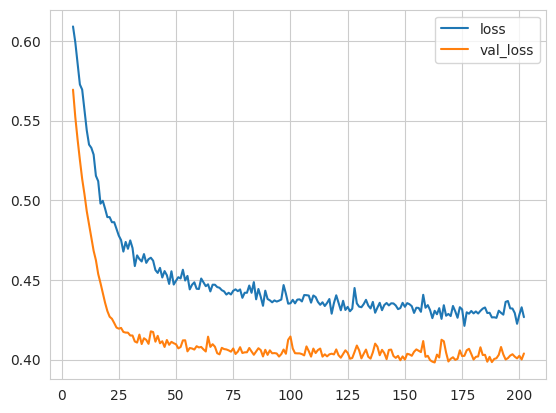

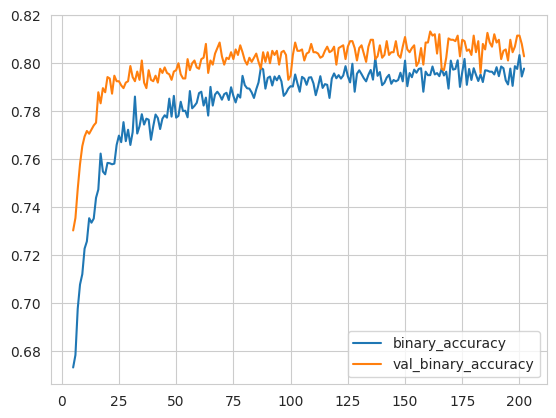

In [43]:
history_df = pd.DataFrame(history.history)
history_df.loc[5:, ["loss", "val_loss"]].plot()
history_df.loc[5:, ["binary_accuracy", "val_binary_accuracy"]].plot()
plt.show()

In [44]:
test_up.shape

(4277, 32)

In [45]:
# make predicitons
predictions = model.predict(test_up)
binary_predictions = (predictions > 0.5).astype("int32")

134/134 [==============================] - 0s 2ms/step


In [46]:
binary_predictions = np.squeeze(binary_predictions)
binary_predictions = binary_predictions.astype(bool)

In [47]:
print(
    "Binary predictions\n",
    binary_predictions.shape,
    type(binary_predictions),
    
    "\nPassenger Id\n",
    test["PassengerId"].values.shape,
    type(test["PassengerId"].values)
)

Binary predictions
 (4277,) <class 'numpy.ndarray'> 
Passenger Id
 (4277,) <class 'numpy.ndarray'>


In [48]:
# create output file
output = pd.DataFrame({"PassengerId": test["PassengerId"].values,
                      "Transported": binary_predictions})
output.to_csv("dnn", index=False)

# Conclusion


- with this model I was able to achieve public score of: **0.80827**
- my leadebord position with this model is 182 / 2667

## How to improve the model even more
- better finetuning of the model itself
- better missing value imputation
- and more and better feature engineering


## Here I tried training DNN with missing values, but I am curently unable to fix it for now, might return later


In [49]:
output

,PassengerId,Transported
0,0013_01,True
1,0018_01,False
2,0019_01,True
3,0021_01,True
4,0023_01,True
...,...,...
4272,9266_02,True
4273,9269_01,False
4274,9271_01,True
4275,9273_01,True


In [50]:
features_num_nan = ["Age", "FoodCourt", "ShoppingMall", "Spa", "VRDeck", "RoomService"]
features_cat_nan = ["HomePlanet", "CryoSleep", "Destination", "VIP"]
target_nan = ["Transported"]

X_nan = train_nan[features_num_nan + features_cat_nan]
y_nan = train_nan[target_nan]

X_train_nan, X_valid_nan, y_train_nan, y_valid_nan = train_test_split(X_nan, y_nan, test_size=0.2, random_state=42, stratify = y_nan)

# ignore missing values
transformer_cat_nan = make_pipeline(
    SimpleImputer(strategy = "constant", fill_value = np.nan),
    OneHotEncoder(sparse = False),
)

transformer_num_nan = make_pipeline(
    SimpleImputer(strategy = "constant", fill_value = np.nan),
    StandardScaler()
)

preprocessor_nan = make_column_transformer(
    (transformer_cat_nan, features_cat_nan),
    (transformer_num_nan, features_num_nan)
)

In [51]:
X_train_nan = preprocessor_nan.fit_transform(X_train_nan)
X_valid_nan = preprocessor_nan.transform(X_valid_nan)

In [52]:
X_train_nan_df = pd.DataFrame(X_train_nan)

In [53]:
X_train_nan_df.describe()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
count,6954.000000,6954.000000,6954.000000,6954.000000,6954.000000,6954.000000,6954.000000,6954.000000,6954.000000,6954.000000,6954.000000,6954.000000,6954.000000,6954.000000,6.815000e+03,6.800000e+03,6.785000e+03,6.804000e+03,6.810000e+03,6.809000e+03
mean,0.528185,0.243313,0.204199,0.024303,0.625539,0.350302,0.024159,0.208801,0.094190,0.675007,0.022002,0.954415,0.022865,0.022721,-5.682257e-17,-3.134747e-17,-8.377807e-18,1.566452e-17,8.347051e-18,-7.304742e-18
std,0.499241,0.429113,0.403144,0.153998,0.484018,0.477099,0.153553,0.406481,0.292114,0.468406,0.146700,0.208599,0.149482,0.149022,1.000073e+00,1.000074e+00,1.000074e+00,1.000073e+00,1.000073e+00,1.000073e+00
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-1.978687e+00,-2.824675e-01,-3.098772e-01,-2.704547e-01,-2.676137e-01,-3.403126e-01
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,-6.680143e-01,-2.824675e-01,-3.098772e-01,-2.704547e-01,-2.676137e-01,-3.403126e-01
50%,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,-1.161522e-01,-2.824675e-01,-3.098772e-01,-2.704547e-01,-2.676137e-01,-3.403126e-01
75%,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,0.000000,6.426582e-01,-2.415900e-01,-2.679609e-01,-2.222950e-01,-2.297247e-01,-2.663797e-01
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,3.470951e+00,1.832336e+01,2.202056e+01,1.935067e+01,1.807789e+01,2.084443e+01


In [54]:
missing = np.isnan(X_train_nan)

In [55]:
missing.sum()

901

In [56]:
input_shape_nan = X_train_nan.shape[1]

In [57]:
input_shape_nan

20

In [58]:
# For some reason, it does not learn anything with missing values. I will return to it later, when I finally resolve this issue

#from keras.optimizers import AdamW
#model = keras.Sequential([
#    layers.Masking(mask_value = np.nan, input_shape=[input_shape_nan]),
#    layers.Dense(32, activation="relu"),
#    layers.Dropout(0.1),
#    layers.BatchNormalization(),
#    layers.Dense(8, activation="relu"),
#    layers.Dropout(0.1),
#    layers.BatchNormalization(),
#    layers.Dense(4, activation="relu"),
#    layers.Dropout(0.1),
#    layers.BatchNormalization(),
#    layers.Dense(1, activation="sigmoid")
#])


#model.compile(
#optimizer = AdamW(learning_rate=0.001),
#loss = "binary_crossentropy",
#metrics = ["binary_accuracy"]
#)

#early_stopping = EarlyStopping(
#min_delta = 0.001,
#patience = 10,
#restore_best_weights = True
#)


## Train the model
#history_nan = model.fit(X_train_nan, y_train_nan, epochs=50, batch_size=64, validation_data=(X_valid_nan, y_valid_nan), callbacks = [early_stopping])

## Evaluate the model
#loss, accuracy = model.evaluate(X_valid_nan, y_valid_nan)
#print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')